# Importacion de las librerias

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.model_selection import KFold, cross_val_score

# Ploting
import matplotlib.pyplot as plt
import colour

# Redes Neuronales
import tensorflow as tf
from tensorflow import keras
import scikeras

# Scikit learn
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                 BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from xgboost import XGBRegressor

# Implementacion de tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard
import datetime
import optuna
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

from time import perf_counter
# from PIL import Image

# Lectura y procesamiento del Dataset

In [2]:
df = pd.read_csv('df_rgb_xyz.csv').drop('Unnamed: 0',axis=1)
df['R'] = df['R'] / 100
df['DEE'] = df['DEE'] / 80
df_test = df
df = df.drop(['z'], axis=1)
print(df.shape)
df.head()

(24635, 8)


R       DEE    Remb         r         g         b         x  \
0  0.101691  0.891269  0.5481  0.607739  0.607748  0.610636  0.312052   
1  0.249168  0.539952  0.3979  0.614463  0.662313  0.545797  0.326839   
2  0.914374  0.211320  0.6341  0.643678  0.632023  0.563976  0.331315   
3  0.859463  0.568773  0.8010  0.667089  0.649641  0.526636  0.344984   
4  0.311980  0.182830  0.3469  0.752189  0.582688  0.540596  0.369491   

          y  
0  0.327911  
1  0.373410  
2  0.354632  
3  0.374364  
4  0.343779

In [3]:
from scipy.stats import gaussian_kde

# Suponiendo que 'df' es tu DataFrame y 'columna1' y 'columna2' son las columnas de interés
# Por ejemplo, df podría ser algo como pd.DataFrame({'columna1': [...], 'columna2': [...]})

# Extraer los valores de las dos columnas y formar una matriz 2D
values = np.vstack([df['x'], df['y']])

# Calcular la densidad de KDE
kde = gaussian_kde(values)

# Evaluar la densidad en cada conjunto de puntos
df['densidad'] = kde(values)

# Filtrar basado en la densidad: si deseas eliminar valores con densidades altas, puedes hacer lo siguiente:
# Establecer un umbral para la densidad
umbral = np.percentile(df['densidad'], 90)  # Ajusta el percentil según sea necesario

# Conservar solo los datos que tienen una densidad por debajo del umbral
df_filtrado = df[df['densidad'] < umbral]
df = df_filtrado.drop(['densidad'], axis=1)
df.shape

(22171, 8)

In [ ]:
df_2 = pd.read_csv('Raw_data.csv')
print(df_2.shape)
# Extraer los valores de las dos columnas y formar una matriz 2D
values = np.vstack([df_2['x'], df_2['y']])

# Calcular la densidad de KDE
kde = gaussian_kde(values)

# Evaluar la densidad en cada conjunto de puntos
df_2['densidad'] = kde(values)

# Filtrar basado en la densidad: si deseas eliminar valores con densidades altas, puedes hacer lo siguiente:
# Establecer un umbral para la densidad
umbral = np.percentile(df_2['densidad'], 70)  # Ajusta el percentil según sea necesario

# Conservar solo los datos que tienen una densidad por debajo del umbral
df_filtrado = df_2[df_2['densidad'] < umbral]
df_2 = df_filtrado.drop(['densidad'], axis=1)
print(df_2.shape)
df_2.describe().T

In [ ]:
df_2['D'] = df_2['D'] / 200
df_2['H'] = df_2['H'] / 100
df_2['T'] = df_2['T'] / 30
df_test_2 = df_2
df_2.head()

In [6]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3234 entries, 0 to 4619
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   D       3234 non-null   float64
 1   H       3234 non-null   float64
 2   T       3234 non-null   float64
 3   x       3234 non-null   float64
 4   y       3234 non-null   float64
dtypes: float64(5)
memory usage: 151.6 KB


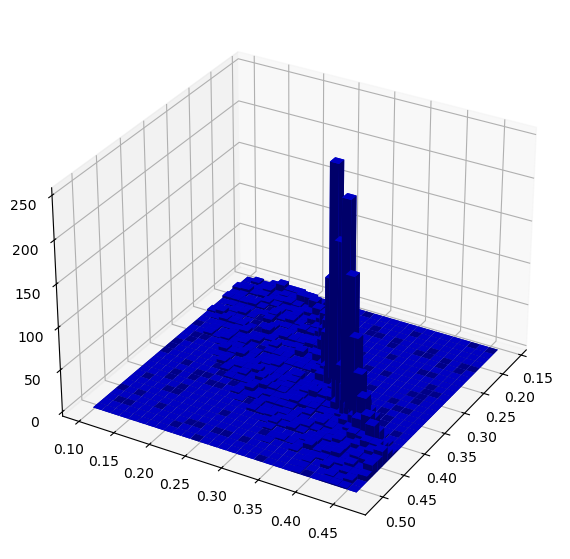

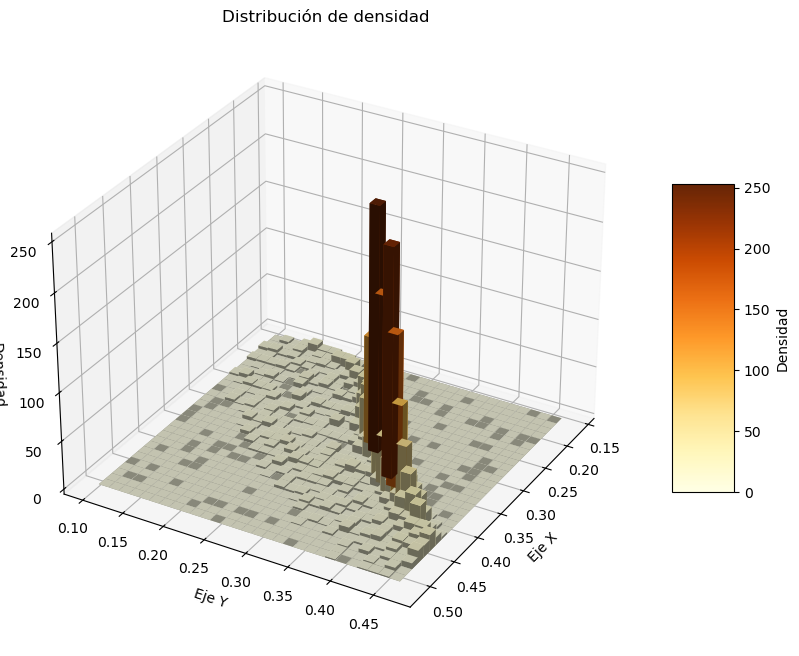

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Supongamos que tienes las siguientes listas o arrays para x e y:
x = df_2['x']
y = df_2['y']

# Calcula los puntos de densidad de KDE
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Creamos una malla regular para evaluar la función de KDE
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
zz = gaussian_kde(xy)(np.vstack([xx.flatten(), yy.flatten()]))
zz = zz.reshape(xx.shape)

# Crea la figura y el eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Configura los límites para los bins
x_bins = np.linspace(x.min(), x.max(), 30)
y_bins = np.linspace(y.min(), y.max(), 30)

# Calcula el histograma 2D
histogram, xedges, yedges = np.histogram2d(x, y, bins=(x_bins, y_bins))

# Posiciones de las barras
xpos, ypos = np.meshgrid(xedges[:-1] + np.diff(xedges)/2, yedges[:-1] + np.diff(yedges)/2)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Altura de las barras
dz = histogram.flatten()

# Tamaño de las barras
dx = dy = np.ones_like(dz) * (xedges[1] - xedges[0])

# Graficar las barras
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

# Ajustar la vista
ax.view_init(elev=30, azim=30)
#=============================================================================================
# Altura de las barras
dz = histogram.flatten()

# Tamaño de las barras
dx = dy = np.ones_like(dz) * (xedges[1] - xedges[0])

# Creamos la figura y el eje 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Para cambiar el color de las barras basado en la densidad, normalizamos 'dz' y creamos un mapa de colores
norm = Normalize(dz.min(), dz.max())
colors = plt.cm.YlOrBr(norm(dz))

# Graficamos las barras con los colores basados en la densidad
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

# Ajustamos la vista
ax.view_init(elev=30, azim=30)

# Creamos el mappable para la barra de color
mappable = ScalarMappable(norm=norm, cmap='YlOrBr')
mappable.set_array(dz)

# Barra de color para la densidad
color_bar = plt.colorbar(mappable, shrink=0.5, aspect=5, ax=ax)
color_bar.set_label('Densidad')

# Etiquetas de los ejes y título
ax.set_title('Distribución de densidad')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Densidad')

plt.show()

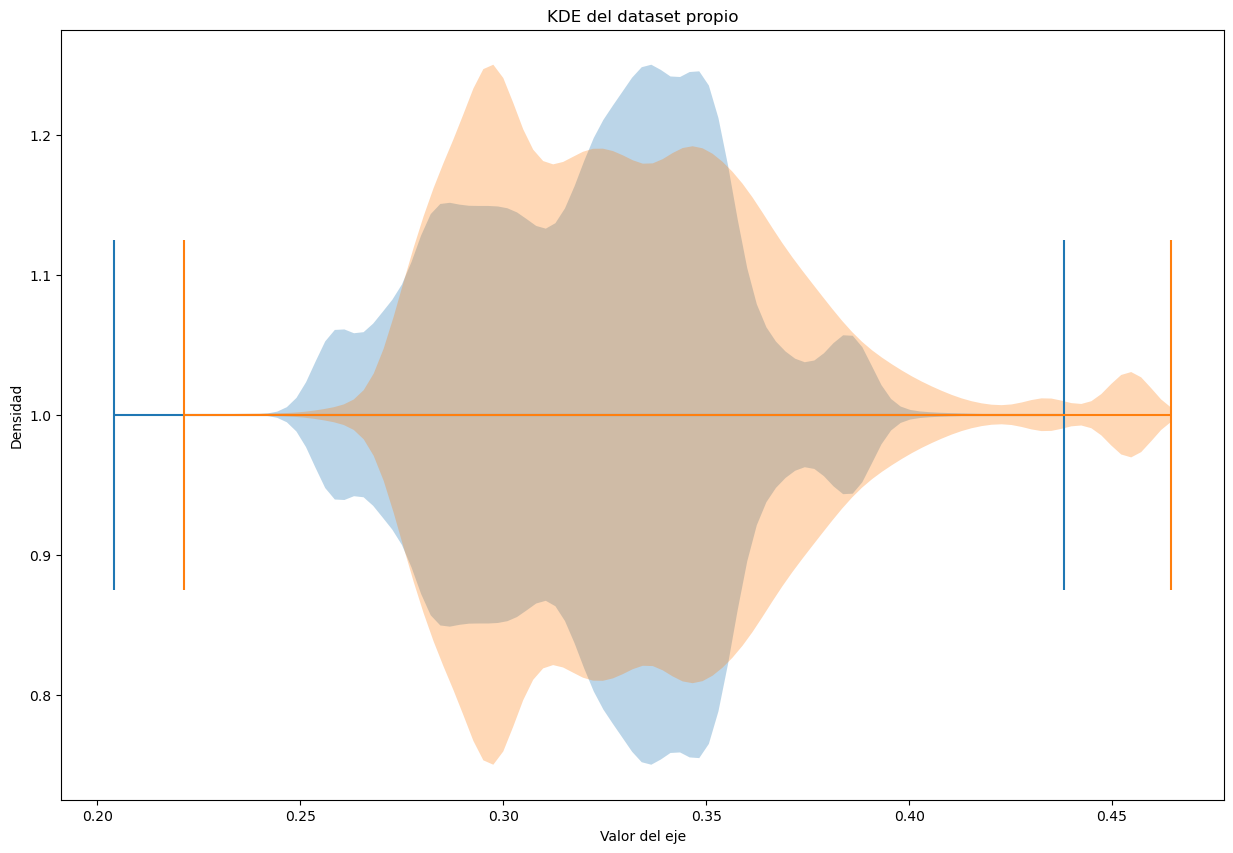

In [8]:
plt.figure(figsize=(15,10))
plt.violinplot(df['x'],vert=False)
plt.violinplot(df['y'],vert=False)
plt.ylabel('Densidad')
plt.xlabel('Valor del eje')
plt.title('KDE del dataset propio')
plt.show()

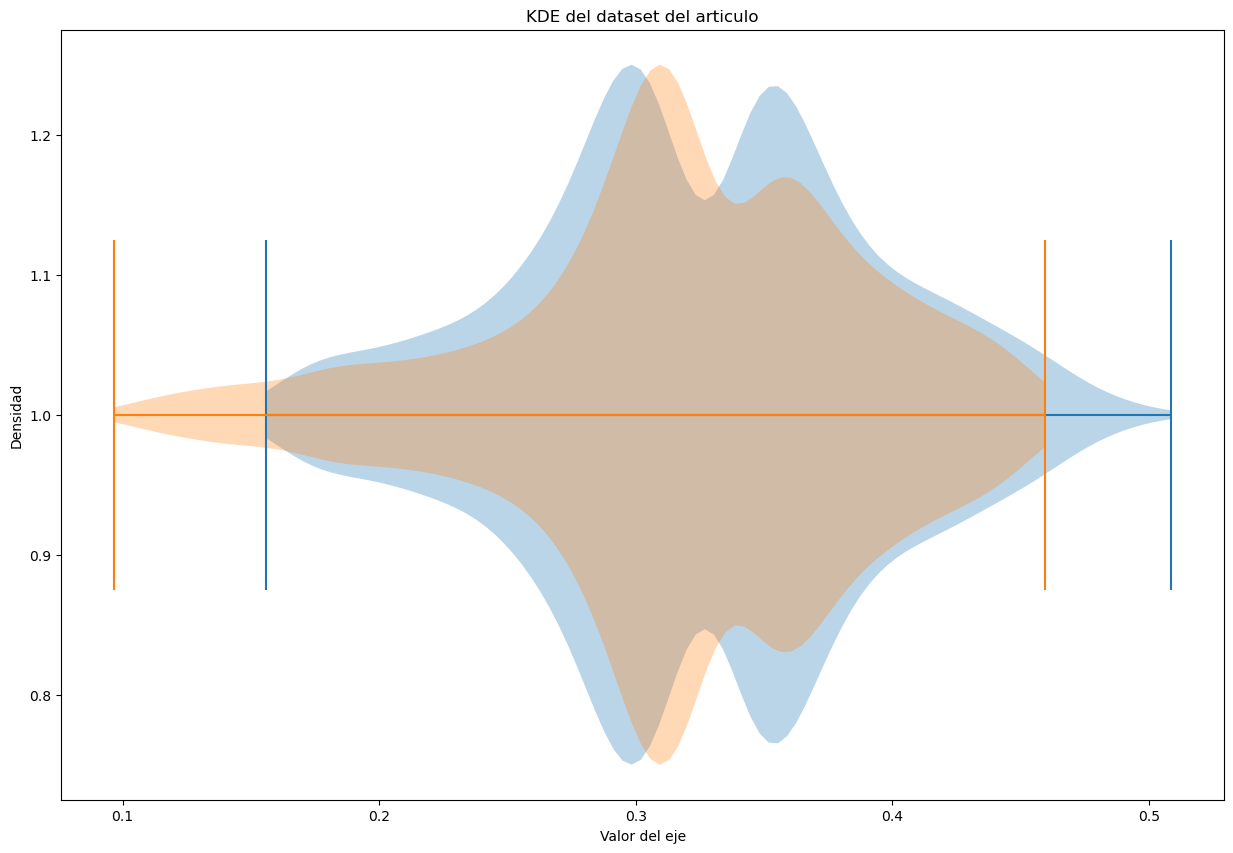

In [9]:
plt.figure(figsize=(15,10))
plt.violinplot(df_2['x'],vert=False)
plt.violinplot(df_2['y'],vert=False)
plt.ylabel('Densidad')
plt.xlabel('Valor del eje')
plt.title('KDE del dataset del articulo')
plt.show()

In [3]:
numero_duplicados = df.duplicated().sum()

if numero_duplicados > 0:
    print(f"Hay {numero_duplicados} filas duplicadas en el DataFrame.")
else:
    print("No hay filas duplicadas en el DataFrame.")

Hay 56 filas duplicadas en el DataFrame.


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
# plt.violinplot(df.r,vert=False)
df.describe().T

count      mean       std       min       25%       50%       75%  \
R     24577.0  0.565412  0.283819  0.050000  0.345268  0.560028  0.803974   
DEE   24577.0  0.474418  0.276595  0.062500  0.233655  0.481486  0.673951   
Remb  24577.0  0.658336  0.188132  0.300000  0.520000  0.690630  0.775500   
r     24577.0  0.627953  0.080788  0.237164  0.574827  0.630769  0.685175   
g     24577.0  0.601178  0.049325  0.363591  0.575097  0.607423  0.629796   
b     24577.0  0.595540  0.063179  0.280018  0.566041  0.606228  0.632765   
x     24577.0  0.321548  0.030298  0.238820  0.300626  0.321979  0.343672   
y     24577.0  0.330573  0.036489  0.221430  0.301340  0.328957  0.351359   

           max  
R     1.000000  
DEE   1.000000  
Remb  1.000000  
r     0.880922  
g     0.740896  
b     0.756195  
x     0.438084  
y     0.464530

# Creacion de los datos de entrenamiento de manera aleatoria

In [6]:
tam = int(df.shape[0]*.05)
tam

1228

In [7]:
import random
random.seed(a=17)
test = [(random.random(), random.random(), random.random()) for i in range(1000)]
print(len(test))
test = pd.DataFrame(test)
test.columns=['r','g','b']
test

1000


r         g         b
0    0.521984  0.806691  0.960495
1    0.289625  0.766107  0.704220
2    0.661383  0.110162  0.026937
3    0.384171  0.746395  0.252384
4    0.501603  0.317435  0.846328
..        ...       ...       ...
995  0.400034  0.083313  0.181476
996  0.693631  0.914663  0.280728
997  0.049622  0.380955  0.980771
998  0.075694  0.143321  0.941641
999  0.734658  0.052012  0.832345

[1000 rows x 3 columns]

In [8]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(df.drop(['R', 'DEE', 'Remb','x','y'],axis=1), df[['R', 'DEE', 'Remb']])

# Prediciendo nuevos datos
predictions = knn.predict(test)
test = pd.DataFrame(predictions)
test.columns=('R','DEE','Remb')
test

R       DEE      Remb
0    0.734497  0.638300  0.456900
1    0.645693  0.569124  0.357100
2    0.775672  0.532375  0.871967
3    0.402796  0.438091  0.522500
4    0.919255  0.896736  0.705899
..        ...       ...       ...
995  0.357678  0.623024  0.300000
996  0.396797  0.449454  0.603000
997  0.842175  0.256820  0.795555
998  0.919255  0.896736  0.705899
999  0.773788  0.537794  0.820604

[1000 rows x 3 columns]

In [9]:
test = pd.merge(test, df[['r', 'g', 'b', 'R', 'DEE', 'Remb','x','y']], 
                  on=['R', 'Remb', 'DEE'], 
                  how='left')
test.head()
x_test = test.drop(['R', 'DEE', 'Remb','x','y'],axis=1)
y_test = test[['R', 'DEE', 'Remb']]
test.head()
x_test.shape,y_test.shape

((1000, 3), (1000, 3))

In [10]:
# Unir df1 con df2 usando un 'inner' merge
merged_df = test.merge(df, how='inner')

# Verificar si todas las filas de df1 están en df2
all_rows_present = len(merged_df) == len(test)
all_rows_present

True

# Sustracion de los datos de entramiento del df original

In [11]:
# Concatenar df1 y df2
concatenated = pd.concat([test, df])

# Eliminar duplicados, manteniendo la primera ocurrencia (es decir, las filas de df1)
concatenated_unique = concatenated.drop_duplicates(keep='first')

# Eliminar las filas que estaban en df1 para obtener el df2 limpio
df = concatenated_unique[~concatenated_unique.index.isin(test.index)]
df.shape

(23378, 8)

In [12]:
df.shape, test.shape

((23378, 8), (1000, 8))

In [13]:
# combined_df = pd.concat([test, df])
# filtered_df = combined_df.drop_duplicates(subset=test.columns.tolist(), keep='last')

# Conserva solo las filas que originalmente estaban en df
# df = filtered_df.iloc[len(test):]
x_df = df.drop(['R', 'DEE', 'Remb','x','y'],axis=1)
y_df = df[['R', 'DEE', 'Remb']] 

In [14]:
x_df.shape, y_df.shape

((23378, 3), (23378, 3))

# Ubicacion de las muestras en el espacio de color CIIE 1931

C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "sho

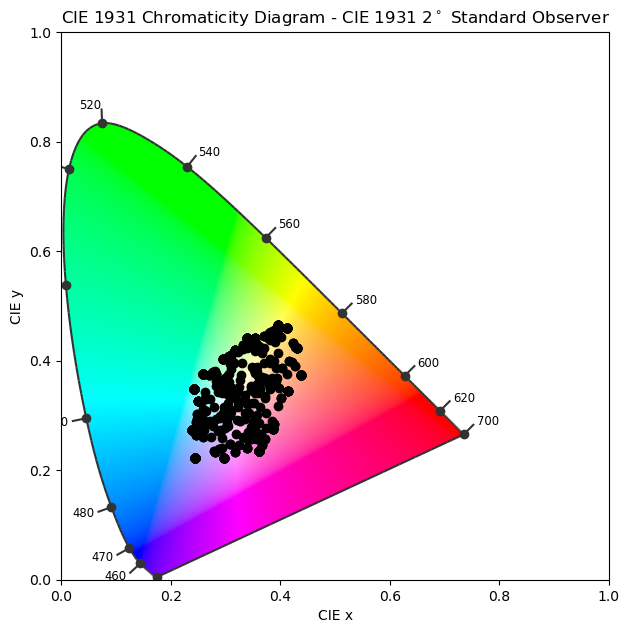

In [15]:
import colour
df_test = pd.merge(test, df_test[['R', 'DEE', 'Remb']], 
                  on=['R', 'Remb', 'DEE'], 
                  how='left')
test.head()

# Define your scatter plot points (CIE xy coordinates)
x = df_test['x']
y = df_test['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

In [16]:
x2_df = df[['x', 'y']]
y2_df = df[['R','DEE','Remb']]
x2_test = df_test[['x', 'y']]
y2_test = df_test[['R','DEE','Remb']]

# Entrenamiento de los modelos

In [20]:
# Creación de listas para el guardado de los resultados de cada entrenamiento
Model = []
NMSE = []
NMAE = []
cv = KFold(10)

# Guardado de los resultados del entrenamiento del algoritmo 
def input_scores(name, model, x, y):
    Model.append(name)
    NMSE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean())
    NMAE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean())

names = ['Linear Regression', 'Lasso Regression', 
         'ElasticNet Regression', 'SVR', 'Gaussian Regressor', 'Bayesian Ridge',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','XGBoost']

models = [LinearRegression(), Lasso(), ElasticNet(),
          SVR(), GaussianProcessRegressor(), BayesianRidge(),
          KNeighborsRegressor(), 
          DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(), XGBRegressor()]

# Entrenamiento de cada modelo de la lista "models" a lo fuerza bruta
for name, model in zip(names, models):
    wrapped_model = MultiOutputRegressor(model)
    input_scores(name, wrapped_model, x_df, y_df)

# Creación de un dataframe a partir de la información recolectada
evaluation = pd.DataFrame({'Model': Model,
                           'MSE' : NMSE})
evaluation

Model       MSE
0             Linear Regression -0.072969
1              Lasso Regression -0.068690
2         ElasticNet Regression -0.068690
3                           SVR -0.058347
4            Gaussian Regressor -0.064954
5                Bayesian Ridge -0.072919
6         K Neighbors Regressor -0.056257
7       Decision Tree Regressor -0.090958
8       Random Forest Regressor -0.055860
9   Gradient Boosting Regressor -0.051172
10           Adaboost Regressor -0.055538
11                      XGBoost -0.052037

## KNNR Multivariable

In [45]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn,x_df, y_df, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-11-06 08:50:53,638] A new study created in memory with name: no-name-c641f2b7-2f9e-4463-aa44-0980254c9b3f
[I 2023-11-06 08:50:55,663] Trial 0 finished with value: -0.17651079214962387 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:56,799] Trial 1 finished with value: -0.17689875395625007 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:57,913] Trial 2 finished with value: -0.17715293972439178 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:58,804] Trial 3 finished with value: -0.17667443670098226 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:58,867] Trial 4 finishe

[I 2023-11-06 08:51:01,343] Trial 39 finished with value: -0.1932665832477221 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 5}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,415] Trial 40 finished with value: -0.17641430123082608 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,489] Trial 41 finished with value: -0.17633993586100855 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,562] Trial 42 finished with value: -0.1764110966382111 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,646] Trial 43 finished with value: -0.17649549184144545 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric':

[I 2023-11-06 08:51:04,218] Trial 78 finished with value: -0.17632011818547227 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,288] Trial 79 finished with value: -0.1764302078579253 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,358] Trial 80 finished with value: -0.1766209267655941 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,429] Trial 81 finished with value: -0.17632011818547227 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,500] Trial 82 finished with value: -0.17649834841160242 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'm

Valor óptimo de neg_mean_squared_error: -0.17609216667804514
Mejores hiperparámetros: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan'}


In [46]:
knn_m = KNeighborsRegressor(n_neighbors=40, weights='distance', metric='manhattan',)
knn_m.fit(x_df , y_df)


KNeighborsRegressor(metric='manhattan', n_neighbors=40, weights='distance')

In [79]:
knn_pred = knn_m.predict(x_test)
mse_knn = mean_squared_error(y_test, knn_pred)
print(mse_knn)

0.0566591645384


## Gradient Boosting

In [67]:
#Busqueda de hiperparametros para GradientBooost
def objective_gbr(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
    model =  MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    ))
    model.fit(x_df, y_df)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

study_gbr = optuna.create_study(direction='minimize')
study_gbr.optimize(objective_gbr, n_trials=100)

[I 2023-11-06 09:08:21,996] A new study created in memory with name: no-name-b8c68f32-4859-4ad5-ad90-82c7f622af0d
[I 2023-11-06 09:08:44,220] Trial 0 finished with value: 0.052515332833364965 and parameters: {'n_estimators': 216, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:09:49,922] Trial 1 finished with value: 0.06363323696564505 and parameters: {'n_estimators': 216, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:10:30,994] Trial 2 finished with value: 0.06453676652610153 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:11:50,293] Trial 3 finished with value: 0.0683351694194652 and parameters: {'n_estimators': 197, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with

[I 2023-11-06 09:25:00,945] Trial 36 finished with value: 0.05593468558555855 and parameters: {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:25:26,466] Trial 37 finished with value: 0.058303125769004295 and parameters: {'n_estimators': 125, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:05,114] Trial 38 finished with value: 0.06535003873420865 and parameters: {'n_estimators': 152, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:31,675] Trial 39 finished with value: 0.05609625895301037 and parameters: {'n_estimators': 173, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:52,652] Trial 40 finished with value: 0.05138917680320293 an

[I 2023-11-06 09:32:07,264] Trial 72 finished with value: 0.04630293066615449 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:13,070] Trial 73 finished with value: 0.046302930666154506 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:18,968] Trial 74 finished with value: 0.046207108061812774 and parameters: {'n_estimators': 57, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:26,804] Trial 75 finished with value: 0.05211933421122807 and parameters: {'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:51,527] Trial 76 finished with value: 0.05237456892555876 

In [75]:
model_gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators = 65,
                                                       max_depth = 2,
                                                       min_samples_split = 5,
                                                       min_samples_leaf = 7))
model_gbr.fit(x_df, y_df)

y_pred_gbr = model_gbr.predict(x_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mse_gbr

0.045655785422287674

## XGBoost

In [43]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    gamma = trial.suggest_float('gamma', 0.0, 0.5, step=0.1)
    model =  MultiOutputRegressor(XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        gamma=gamma
    ))
    model.fit(x_df, y_df)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2023-11-06 08:48:20,779] A new study created in memory with name: no-name-09e49e24-3152-4f97-8b09-63c3b7c87254
[I 2023-11-06 08:48:21,024] Trial 0 finished with value: 0.05378792107613322 and parameters: {'n_estimators': 224, 'max_depth': 6, 'gamma': 0.5}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,176] Trial 1 finished with value: 0.057164962733397016 and parameters: {'n_estimators': 114, 'max_depth': 8, 'gamma': 0.5}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,464] Trial 2 finished with value: 0.058195287061275726 and parameters: {'n_estimators': 259, 'max_depth': 6, 'gamma': 0.1}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,757] Trial 3 finished with value: 0.057913601915384715 and parameters: {'n_estimators': 268, 'max_depth': 8, 'gamma': 0.4}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,889] Trial 4 finished with value: 0.05433770159615662 and parameters: {'n_estima

[I 2023-11-06 08:48:29,916] Trial 41 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 250, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,214] Trial 42 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 265, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,531] Trial 43 finished with value: 0.057224898107797684 and parameters: {'n_estimators': 283, 'max_depth': 3, 'gamma': 0.5}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,671] Trial 44 finished with value: 0.047054789691425215 and parameters: {'n_estimators': 87, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,928] Trial 45 finished with value: 0.052539323622002 and parameters: {'n_estimators': 208, 'max_depth': 6, 'gamma': 0.30000000000000004}. Best is trial 19 with value: 0.0470547875068

[I 2023-11-06 08:48:40,983] Trial 82 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 213, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,259] Trial 83 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 238, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,476] Trial 84 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 166, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,790] Trial 85 finished with value: 0.057636289248645195 and parameters: {'n_estimators': 279, 'max_depth': 3, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:42,070] Trial 86 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 243, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 20

In [76]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators = 88,
                                             max_depth = 2,
                                             gamma = 0.4))
model_xgb.fit(x_df, y_df)

y_pred_xgb = model_xgb.predict(x_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_xgb

0.047054789654397612

In [80]:
models_scikit = pd.DataFrame({'Model': ['KNN', 'GBR', 'XGBR'],
                           'MSE' : [mse_knn, mse_gbr, mse_xgb]})
models_scikit

Model       MSE
0   KNN  0.056659
1   GBR  0.045656
2  XGBR  0.047055

# TensorFlow

## Modelo de referencia

### CIE XY

In [33]:
model_ref_2_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])

model_ref_2_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanSquaredError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_2_ins = model_ref_2_ins.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

model_ref_2_ins.evaluate(x2_test, y2_test)

Epoch 1/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0677 - val_mean_squared_error: 0.0677
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 4/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 6/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0508 - val_mean_squared_error: 0.0508
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0545 - val_mean_squared_error: 0.0545
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0579 - val_mean_squared_error: 0.0579
Epoch 55/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 56/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 57/5

731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 150/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 155/5000
731/

[0.042460959404706955, 0.042460959404706955]

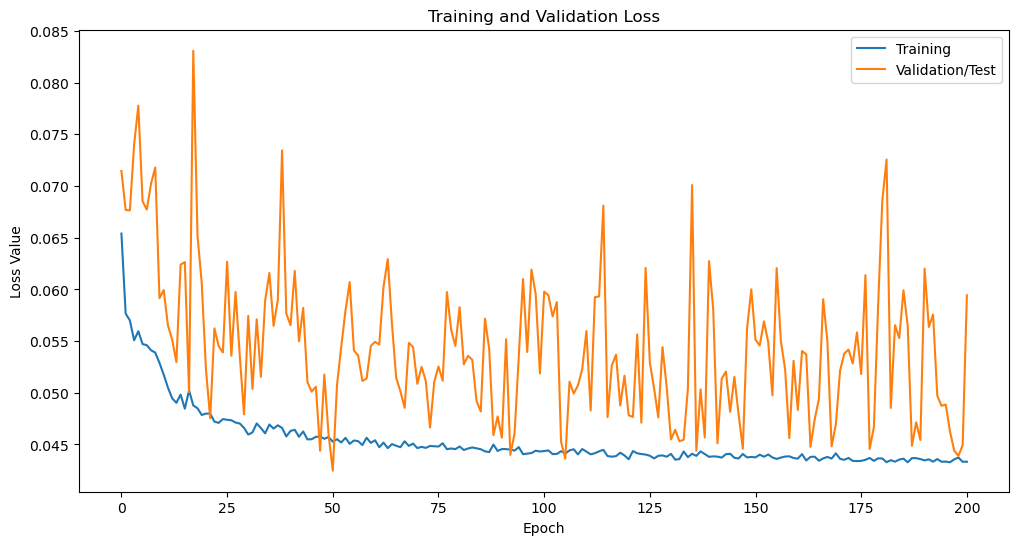

In [34]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_ref_2_ins.history['mean_squared_error'], label='Training')
plt.plot(history_model_ref_2_ins.history['val_mean_squared_error'], label='Validation/Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

### sRGB

In [355]:
model_ref_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])

model_ref_3_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanSquaredError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_3_ins = model_ref_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_ref_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 8s 10ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 2/5000
731/731 [==============================] - 7s 9ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 3/5000
731/731 [==============================] - 5s 8ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 4/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0789 - val_mean_squared_error: 0.0789
Epoch 5/5000
731/731 [==============================] - 6s 8ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 6/5000
731/731 [==============================] - 7s 9ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0599 - val_mean_squared_error: 0.0599
Epoch 7/5000
73

Epoch 51/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0647 - val_mean_squared_error: 0.0647
Epoch 52/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 53/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 54/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 55/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoch 56/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 57/5

731/731 [==============================] - 5s 7ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0567 - val_mean_squared_error: 0.0567
Epoch 150/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 151/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 152/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 153/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Epoch 154/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 155/5000
731/

731/731 [==============================] - 5s 7ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0624 - val_mean_squared_error: 0.0624
Epoch 248/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 249/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 250/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 251/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 252/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 253/5000
731/

731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 346/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 347/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 348/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 349/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 350/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 351/5000
731/

[0.033210527151823044, 0.033210527151823044]

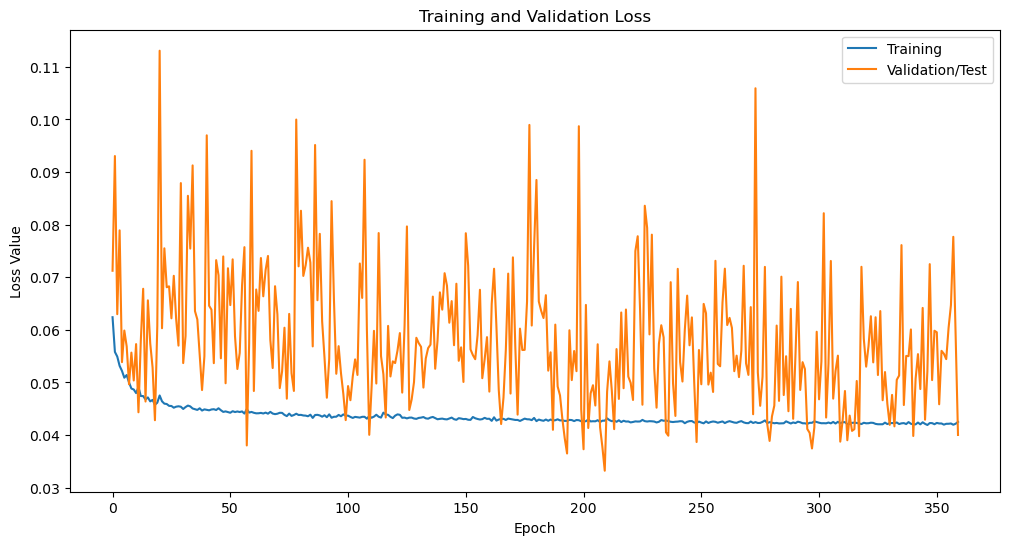

In [356]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_ref_3_ins.history['mean_squared_error'], label='Training')
plt.plot(history_model_ref_3_ins.history['val_mean_squared_error'], label='Validation/Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

## Busqueda de hiperparametros

In [354]:
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
    
    model = keras.Sequential([
        keras.layers.Dense(1024, input_shape=(3,), activation=activation_1, kernel_initializer=init_mode_1, kernel_regularizer = regularizer),
        keras.layers.Dense(512, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(256, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(128, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(64, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(32, activation=activation_6, kernel_initializer=init_mode_6),
#         keras.layers.Dense(neuron_7, activation=activation_7, kernel_initializer=init_mode_7),
#         keras.layers.Dense(neuron_8, activation=activation_8, kernel_initializer=init_mode_8),
#         keras.layers.Dense(4, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3)
    ])
    model.compile(optimizer= optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanSquaredError(),])
    return model

# Función objetivo para Optuna
def objective(trial):
#     neuron_1 = trial.suggest_int('neuron_1', 3, 1024)
#     neuron_2 = trial.suggest_int('neuron_2', 3, 1024)
#     neuron_3 = trial.suggest_int('neuron_3', 3, 1024)
#     neuron_4 = trial.suggest_int('neuron_4', 3, 1024)
#     neuron_5 = trial.suggest_int('neuron_5', 3, 1024)
#     neuron_6 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_7 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_8 = trial.suggest_int('neuron_6', 3, 1024)
    
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
#     activation_7 = trial.suggest_categorical('activation_7', activations_list)
#     activation_8 = trial.suggest_categorical('activation_8', activations_list)
#     activation_9 = trial.suggest_categorical('activation_9', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
#     init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
#     init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
#     init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])
    
    optimizer = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer)
    
    history = model.fit(x_df, y_df, epochs=10, validation_data=(x_test, y_test), verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['val_mean_squared_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)


[I 2023-11-09 14:40:05,387] A new study created in memory with name: no-name-1f1ecd2e-a428-44f9-906c-499d96e79bc5
[I 2023-11-09 14:40:40,955] Trial 0 finished with value: 0.05078951641917229 and parameters: {'activation_1': 'softplus', 'activation_2': 'linear', 'activation_3': 'selu', 'activation_4': 'swish', 'activation_5': 'softmax', 'activation_6': 'exponential', 'init_mode_1': 'zero', 'init_mode_2': 'zero', 'init_mode_3': 'uniform', 'init_mode_4': 'normal', 'init_mode_5': 'uniform', 'init_mode_6': 'lecun_uniform', 'regularizer_type': 'l2', 'optimizer': 'Adam'}. Best is trial 0 with value: 0.05078951641917229.
[I 2023-11-09 14:41:12,559] Trial 1 finished with value: 0.051626354455947876 and parameters: {'activation_1': 'selu', 'activation_2': 'exponential', 'activation_3': 'selu', 'activation_4': 'relu', 'activation_5': 'linear', 'activation_6': 'exponential', 'init_mode_1': 'uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'lecun_uniform', '

[I 2023-11-09 14:53:07,222] Trial 16 finished with value: 0.06786269694566727 and parameters: {'activation_1': 'hard_sigmoid', 'activation_2': 'softmax', 'activation_3': 'linear', 'activation_4': 'linear', 'activation_5': 'swish', 'activation_6': 'linear', 'init_mode_1': 'he_normal', 'init_mode_2': 'normal', 'init_mode_3': 'normal', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'uniform', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 14:54:16,789] Trial 17 finished with value: 0.07064512372016907 and parameters: {'activation_1': 'softmax', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'hard_sigmoid', 'activation_5': 'tanh', 'activation_6': 'selu', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. B

[I 2023-11-09 15:09:51,949] Trial 32 finished with value: 0.056636832654476166 and parameters: {'activation_1': 'swish', 'activation_2': 'exponential', 'activation_3': 'selu', 'activation_4': 'softsign', 'activation_5': 'linear', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'zero', 'init_mode_2': 'zero', 'init_mode_3': 'normal', 'init_mode_4': 'normal', 'init_mode_5': 'uniform', 'init_mode_6': 'lecun_uniform', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:11:04,485] Trial 33 finished with value: 0.05885032191872597 and parameters: {'activation_1': 'hard_sigmoid', 'activation_2': 'softmax', 'activation_3': 'exponential', 'activation_4': 'sigmoid', 'activation_5': 'relu', 'activation_6': 'exponential', 'init_mode_1': 'zero', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'uniform', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'glorot_uniform', 'regularizer_type': None, 'optimizer': 'RMS

[I 2023-11-09 15:23:46,809] Trial 48 finished with value: 0.054378725588321686 and parameters: {'activation_1': 'tanh', 'activation_2': 'softplus', 'activation_3': 'linear', 'activation_4': 'elu', 'activation_5': 'selu', 'activation_6': 'softmax', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'zero', 'init_mode_4': 'glorot_normal', 'init_mode_5': 'uniform', 'init_mode_6': 'normal', 'regularizer_type': 'l2', 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:24:48,338] Trial 49 finished with value: 0.04369107633829117 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'softmax', 'activation_5': 'softmax', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_normal', 'init_mode_2': 'uniform', 'init_mode_3': 'he_uniform', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'zero', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is tria

[I 2023-11-09 15:38:59,047] Trial 64 finished with value: 0.0556495301425457 and parameters: {'activation_1': 'relu', 'activation_2': 'softmax', 'activation_3': 'relu', 'activation_4': 'softmax', 'activation_5': 'softsign', 'activation_6': 'swish', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'he_normal', 'init_mode_4': 'he_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:39:57,603] Trial 65 finished with value: 0.06139164790511131 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'relu', 'activation_4': 'softmax', 'activation_5': 'softsign', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'he_normal', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimize

[I 2023-11-09 15:54:20,986] Trial 80 finished with value: 0.05585189908742905 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'linear', 'activation_4': 'hard_sigmoid', 'activation_5': 'selu', 'activation_6': 'linear', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:54:55,946] Trial 81 finished with value: 0.052430152893066406 and parameters: {'activation_1': 'tanh', 'activation_2': 'selu', 'activation_3': 'sigmoid', 'activation_4': 'elu', 'activation_5': 'relu', 'activation_6': 'softplus', 'init_mode_1': 'zero', 'init_mode_2': 'he_normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'uniform', 'regularizer_type': 'l2', 'optimizer': 'SGD

[I 2023-11-09 16:10:08,023] Trial 96 finished with value: 0.0554620660841465 and parameters: {'activation_1': 'sigmoid', 'activation_2': 'softmax', 'activation_3': 'sigmoid', 'activation_4': 'hard_sigmoid', 'activation_5': 'swish', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'he_normal', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 16:11:13,760] Trial 97 finished with value: 0.050173353403806686 and parameters: {'activation_1': 'swish', 'activation_2': 'exponential', 'activation_3': 'swish', 'activation_4': 'sigmoid', 'activation_5': 'swish', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'lecun_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'he_uniform', 'init_mode_4': 'he_normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimi

Mejores hiperparámetros: {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'sigmoid', 'activation_5': 'selu', 'activation_6': 'softplus', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}


In [32]:
# Crear el modelo
model_2_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(2,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_2_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)
# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)

# Entrenar el modelo y guardar el historial
history = model_2_ins.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

model_2_ins.evaluate(x2_test, y2_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 2/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 3/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0819 - val_mean_squared_error: 0.0819
Epoch 4/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0867 - val_mean_squared_error: 0.0867
Epoch 6/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0797 - val_mean_squared_error: 0.0797
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 55/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 56/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 57/5

731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 150/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0876 - val_mean_squared_error: 0.0876
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0867 - val_mean_squared_error: 0.0867
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0688 - val_mean_squared_error: 0.0688
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 155/5000
731/

[0.03675910085439682, 0.03675910085439682]

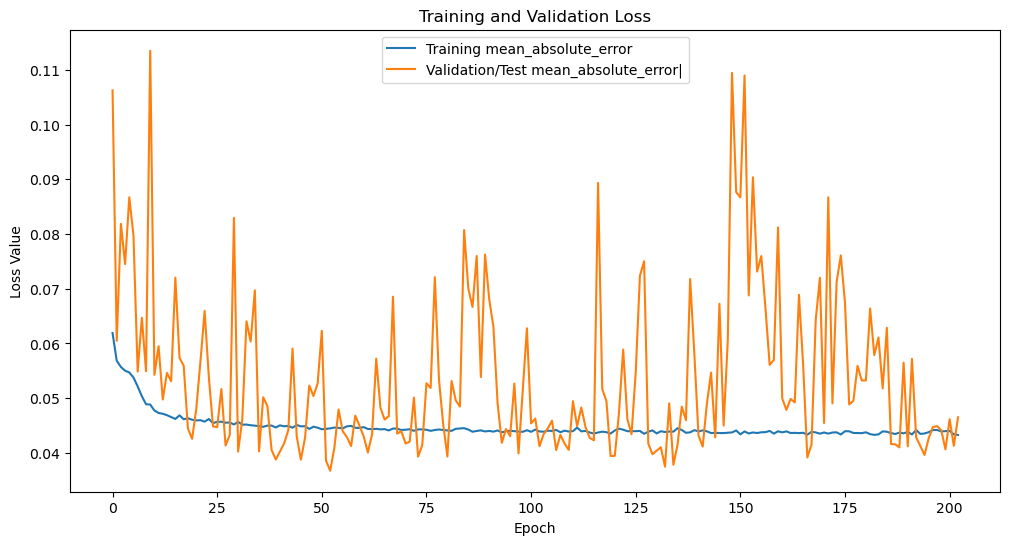

In [35]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [18]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 3/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 6/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0610 - val_mean_squared_error: 0.0610
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 55/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0544 - val_mean_squared_error: 0.0544
Epoch 56/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 57/5

731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 150/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.1085 - val_mean_squared_error: 0.1085
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0991 - val_mean_squared_error: 0.0991
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.1005 - val_mean_squared_error: 0.1005
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 155/5000
731/

731/731 [==============================] - 3s 4ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 248/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 249/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 250/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.1340 - val_mean_squared_error: 0.1340
Epoch 251/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1120 - val_mean_squared_error: 0.1120
Epoch 252/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0882 - val_mean_squared_error: 0.0882
Epoch 253/5000
731/

731/731 [==============================] - 4s 6ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.1098 - val_mean_squared_error: 0.1098
Epoch 346/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 347/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.4399 - val_mean_squared_error: 0.4399
Epoch 348/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.1577 - val_mean_squared_error: 0.1577
Epoch 349/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.1083 - val_mean_squared_error: 0.1083
Epoch 350/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.1308 - val_mean_squared_error: 0.1308
Epoch 351/5000
731/

[0.03349746763706207, 0.03349746763706207]

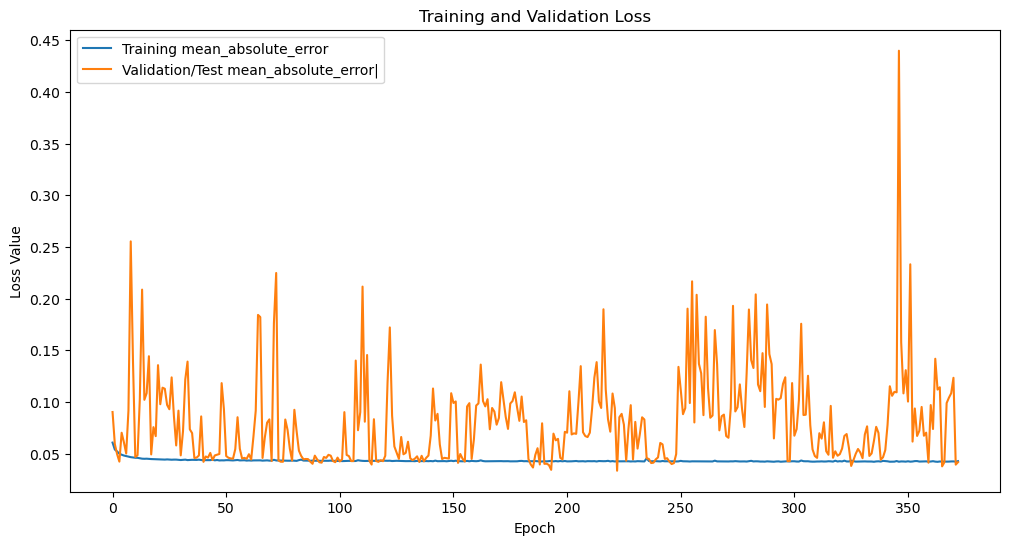

In [19]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [40]:
# Crear el modelo
start=perf_counter()

model_3_ins_1 = None
model_3_ins_1 = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=150, mode='min' ,restore_best_weights=True)
    
# Entrenar el modelo y guardar el historial
history_model_3_ins_1 = model_3_ins_1.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f hrs.' %tl)

model_3_ins_1.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0622 - mean_absolute_percentage_error: 79.0168 - val_loss: 0.0620 - val_mean_absolute_percentage_error: 33.4709
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0549 - mean_absolute_percentage_error: 72.5860 - val_loss: 0.0614 - val_mean_absolute_percentage_error: 35.3475
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0528 - mean_absolute_percentage_error: 68.3835 - val_loss: 0.0603 - val_mean_absolute_percentage_error: 33.7018
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0507 - mean_absolute_percentage_error: 63.8929 - val_loss: 0.0434 - val_mean_absolute_percentage_error: 33.7062
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0498 - mean_absolute_percentage_error: 61.8869 - val_loss: 0.0480 - val_mean_absolute_percentage_error: 34.0561
Epoch 6/5000
731/731 [============================

Epoch 44/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0443 - mean_absolute_percentage_error: 53.4657 - val_loss: 0.1102 - val_mean_absolute_percentage_error: 42.8270
Epoch 45/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0441 - mean_absolute_percentage_error: 53.4233 - val_loss: 0.0600 - val_mean_absolute_percentage_error: 36.4253
Epoch 46/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0442 - mean_absolute_percentage_error: 53.7673 - val_loss: 0.0599 - val_mean_absolute_percentage_error: 33.7879
Epoch 47/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0441 - mean_absolute_percentage_error: 53.2478 - val_loss: 0.0460 - val_mean_absolute_percentage_error: 30.4588
Epoch 48/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0439 - mean_absolute_percentage_error: 53.1541 - val_loss: 0.0500 - val_mean_absolute_percentage_error: 32.4849
Epoch 49/5000
731/731 [======================

Epoch 87/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_absolute_percentage_error: 52.9019 - val_loss: 0.0525 - val_mean_absolute_percentage_error: 33.1340
Epoch 88/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0436 - mean_absolute_percentage_error: 52.6642 - val_loss: 0.0365 - val_mean_absolute_percentage_error: 30.8426
Epoch 89/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0438 - mean_absolute_percentage_error: 53.0935 - val_loss: 0.0436 - val_mean_absolute_percentage_error: 32.1806
Epoch 90/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0446 - mean_absolute_percentage_error: 54.0652 - val_loss: 0.0413 - val_mean_absolute_percentage_error: 32.2169
Epoch 91/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0451 - mean_absolute_percentage_error: 54.5208 - val_loss: 0.0675 - val_mean_absolute_percentage_error: 33.5287
Epoch 92/5000
731/731 [======================

Epoch 130/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.5419 - val_loss: 0.0447 - val_mean_absolute_percentage_error: 32.1767
Epoch 131/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0432 - mean_absolute_percentage_error: 52.3871 - val_loss: 0.0587 - val_mean_absolute_percentage_error: 33.7177
Epoch 132/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0435 - mean_absolute_percentage_error: 52.7740 - val_loss: 0.0464 - val_mean_absolute_percentage_error: 31.1504
Epoch 133/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.4559 - val_loss: 0.0602 - val_mean_absolute_percentage_error: 34.5595
Epoch 134/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.6277 - val_loss: 0.1093 - val_mean_absolute_percentage_error: 42.9143
Epoch 135/5000
731/731 [================

Epoch 173/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.4780 - val_loss: 0.3352 - val_mean_absolute_percentage_error: 48.6623
Epoch 174/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.4687 - val_loss: 0.4708 - val_mean_absolute_percentage_error: 57.9808
Epoch 175/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.7371 - val_loss: 0.0914 - val_mean_absolute_percentage_error: 38.4473
Epoch 176/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_absolute_percentage_error: 52.1314 - val_loss: 0.1978 - val_mean_absolute_percentage_error: 46.5057
Epoch 177/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_absolute_percentage_error: 52.0264 - val_loss: 0.1602 - val_mean_absolute_percentage_error: 42.6302
Epoch 178/5000
731/731 [================

[0.03712292015552521, 27.90331268310547]

In [ ]:
22.25

14.24

In [ ]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins_1.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins_1.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [384]:
# Crear el modelo
model_3_ins_2 = None
model_3_ins_2 = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


# optimizer = tf.keras.optimizers.Adam(
# #     learning_rate=0.001,
# #     rho=0.9,
# #     momentum=0.5,
# #     epsilon=1e-07,
# #     centered=True,
# #     weight_decay=0.0001,
# )

# Compilación del modelo
model_3_ins_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins_2 = model_3_ins_2.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins_2.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0920 - val_mean_squared_error: 0.0920
Epoch 3/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 5/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 6/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 52/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 53/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.2031 - val_mean_squared_error: 0.2031
Epoch 54/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 55/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 56/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 57/5

731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0819 - val_mean_squared_error: 0.0819
Epoch 150/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 151/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.2602 - val_mean_squared_error: 0.2602
Epoch 152/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 153/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 154/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.1281 - val_mean_squared_error: 0.1281
Epoch 155/5000
731/

731/731 [==============================] - 4s 5ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 248/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0711 - val_mean_squared_error: 0.0711
Epoch 249/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 250/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1162 - val_mean_squared_error: 0.1162
Epoch 251/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.1924 - val_mean_squared_error: 0.1924
Epoch 252/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 253/5000
731/

731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.4197 - val_mean_squared_error: 0.4197
Epoch 346/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 347/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.4729 - val_mean_squared_error: 0.4729
Epoch 348/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.4538 - val_mean_squared_error: 0.4538
Epoch 349/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.5261 - val_mean_squared_error: 0.5261
Epoch 350/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 351/5000
731/

[0.036182548850774765, 0.036182548850774765]

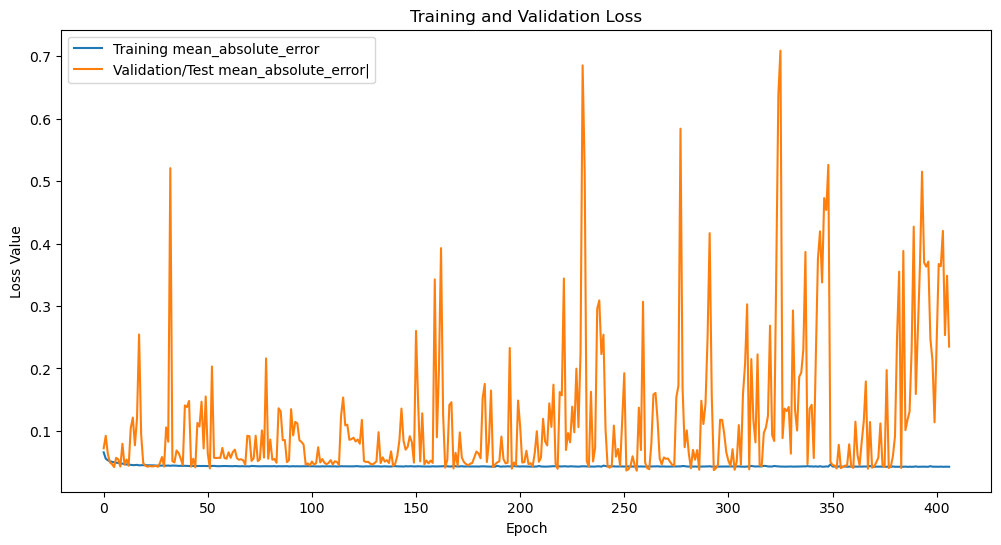

In [385]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins_2.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins_2.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Testing Phase

In [ ]:
cie2rgb = keras.Sequential([
    keras.layers.Dense(512, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(3)
])

cie2rgb.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=10, mode='min' ,restore_best_weights=True)

cie2rgb.fit(x2_df,  x_df, epochs=5000, validation_data=(x2_test, x_test), callbacks=[callback])

cie2rgb.evaluate(x2_test, x_test)

In [ ]:
df_2.head()

In [ ]:
rgb_values = cie2rgb.predict(df_2[['x','y']])

In [ ]:
rgb_df = pd.DataFrame(rgb_values, columns=['r','g','b'])
rgb_df.index = df_2.index
df_2 = pd.concat([df_2, rgb_df], axis=1)
df_2.head()

In [ ]:
import random
random.seed(a=17)
test_2 = [(random.random(), random.random(), random.random()) for i in range(500)]
print(len(test_2))
test_2 = pd.DataFrame(test_2)
test_2.columns=['r','g','b']
test_2

In [ ]:
df_2

In [ ]:
knn_2 = KNeighborsRegressor(n_neighbors=1)
knn_2.fit(df_2.drop(['D', 'H', 'T','x','y'],axis=1), df_2[['D', 'H', 'T']])

# Prediciendo nuevos datos
predictions = knn_2.predict(test_2)
test_2 = pd.DataFrame(predictions)
test_2.columns=('D','H','T')
test_2

In [ ]:
test_2 = pd.merge(test_2, df_2[['r', 'g', 'b', 'D', 'H', 'T','x','y']], 
                  on=['D', 'H', 'T'], 
                  how='left')

x_test_2 = test_2.drop(['D', 'H', 'T','x','y'],axis=1)
y_test_2 = test_2[['D', 'H', 'T']]
x_test_2.shape,y_test_2.shape

In [ ]:
y_test_2.head()

In [ ]:
# Unir df1 con df2 usando un 'inner' merge
merged_df = test_2.merge(df_2, how='inner')

# Verificar si todas las filas de df1 están en df2
all_rows_present = len(merged_df) == len(test_2)
all_rows_present

In [ ]:
# Concatenar df1 y df2
concatenated = pd.concat([test_2, df_2])

# Eliminar duplicados, manteniendo la primera ocurrencia (es decir, las filas de df1)
concatenated_unique = concatenated.drop_duplicates(keep='first')

# Eliminar las filas que estaban en df1 para obtener el df2 limpio
df_2 = concatenated_unique[~concatenated_unique.index.isin(test_2.index)]
df_2.shape

In [ ]:
df_2.shape, test_2.shape

In [ ]:
y_train_2 = df_2[['D', 'H', 'T']] 
x_train_2_rgb = df_2[['r','g','b']]
x_train_2_xy = df_2[['x','y']]

In [ ]:
x_train_2_rgb.shape, y_train_2.shape

In [ ]:
import colour
df_test_2 = pd.merge(test_2, df_test_2[['D', 'H', 'T']], 
                  on=['D', 'H', 'T'], 
                  how='left')

# Define your scatter plot points (CIE xy coordinates)
x = df_test_2['x']
y = df_test_2['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

In [ ]:
y_test_2 = test_2[['D','H','T']]

x_test_2_rgb = test_2[['r','g','b']]

x_test_2_xy = test_2[['x','y',]]

x_train_2_rgb.shape, y_test_2.shape

In [39]:
# df_2 = utils.shuffle(df_2, random_state = 10)
# x_train, x_test, y_train, y_test = train_test_split(df_2[['y','x']], df_2[['D','H','T']],test_size=0.2,random_state=17)
# x_train.shape,x_test.shape

((2137, 2), (535, 2))

In [18]:
model_ref_2_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'sigmoid'),
    keras.layers.Dense(3)
])

model_ref_2_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2500, mode='min' ,restore_best_weights=True)

history_model_ref_2_ins = model_ref_2_ins.fit(x_train_2_xy,  y_train_2, epochs=5000, validation_data=(x_test_2_xy, y_test_2), callbacks=[callback])



NameError: name 'x_train_2_xy' is not defined

In [47]:
model_ref_2_ins.evaluate(x_test_2_xy, y_test_2)

16/16 [==============================] - 0s 3ms/step - loss: 0.0133 - mean_absolute_percentage_error: 15.1662


[0.013299782760441303, 15.166234970092773]

##########################################################################################

In [50]:
model_ref_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'sigmoid'),
    keras.layers.Dense(3)
])

model_ref_3_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2500, mode='min' ,restore_best_weights=True)

history_model_ref_3_ins = model_ref_3_ins.fit(x_train_2_rgb, y_train_2, epochs=5000, validation_data=(x_test_2_rgb, y_test_2), callbacks=[callback])



Epoch 1/5000
84/84 [==============================] - 1s 8ms/step - loss: 0.0557 - mean_absolute_percentage_error: 38.4222 - val_loss: 0.1011 - val_mean_absolute_percentage_error: 77.6640
Epoch 2/5000
84/84 [==============================] - 0s 5ms/step - loss: 0.0507 - mean_absolute_percentage_error: 37.3306 - val_loss: 0.0657 - val_mean_absolute_percentage_error: 59.6057
Epoch 3/5000
84/84 [==============================] - 0s 5ms/step - loss: 0.0495 - mean_absolute_percentage_error: 36.5365 - val_loss: 0.0592 - val_mean_absolute_percentage_error: 53.2693
Epoch 4/5000
84/84 [==============================] - 0s 5ms/step - loss: 0.0473 - mean_absolute_percentage_error: 35.5355 - val_loss: 0.0592 - val_mean_absolute_percentage_error: 55.3369
Epoch 5/5000
84/84 [==============================] - 0s 5ms/step - loss: 0.0481 - mean_absolute_percentage_error: 35.8264 - val_loss: 0.0545 - val_mean_absolute_percentage_error: 46.7801
Epoch 6/5000
84/84 [==============================] - 0s 5ms

Epoch 345/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0319 - mean_absolute_percentage_error: 26.4671 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.2452
Epoch 346/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0316 - mean_absolute_percentage_error: 26.2063 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 28.0750
Epoch 347/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0312 - mean_absolute_percentage_error: 26.0601 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 31.1010
Epoch 348/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0318 - mean_absolute_percentage_error: 26.3771 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 28.2615
Epoch 349/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0303 - mean_absolute_percentage_error: 25.5639 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 30.2522
Epoch 350/5000
108/108 [================

Epoch 388/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0314 - mean_absolute_percentage_error: 26.1709 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 27.3494
Epoch 389/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0313 - mean_absolute_percentage_error: 26.0874 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 28.7671
Epoch 390/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0306 - mean_absolute_percentage_error: 25.6759 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 30.1139
Epoch 391/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_absolute_percentage_error: 25.6389 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 30.3765
Epoch 392/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0335 - mean_absolute_percentage_error: 27.2159 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 27.2489
Epoch 393/5000
108/108 [================

Epoch 431/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 25.4258 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 31.4364
Epoch 432/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0349 - mean_absolute_percentage_error: 28.0554 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 36.5475
Epoch 433/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0312 - mean_absolute_percentage_error: 25.8868 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 29.0841
Epoch 434/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0303 - mean_absolute_percentage_error: 25.6507 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 28.1313
Epoch 435/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0308 - mean_absolute_percentage_error: 25.7345 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 27.7526
Epoch 436/5000
108/108 [================

Epoch 474/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0314 - mean_absolute_percentage_error: 25.9017 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 27.4123
Epoch 475/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0312 - mean_absolute_percentage_error: 26.1184 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 31.5476
Epoch 476/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_absolute_percentage_error: 25.7388 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 28.3603
Epoch 477/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0315 - mean_absolute_percentage_error: 26.2825 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 30.0906
Epoch 478/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0309 - mean_absolute_percentage_error: 25.9207 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 29.0874
Epoch 479/5000
108/108 [================

Epoch 517/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 25.2071 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 29.4463
Epoch 518/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0301 - mean_absolute_percentage_error: 25.1798 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 27.1569
Epoch 519/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0309 - mean_absolute_percentage_error: 25.8680 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 28.7322
Epoch 520/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0299 - mean_absolute_percentage_error: 25.2269 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 29.7133
Epoch 521/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0300 - mean_absolute_percentage_error: 25.2484 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 27.3817
Epoch 522/5000
108/108 [================

Epoch 560/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 25.0660 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 28.5049
Epoch 561/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.6320 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.0087
Epoch 562/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 25.0003 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 30.0329
Epoch 563/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 25.0837 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 26.2043
Epoch 564/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0301 - mean_absolute_percentage_error: 25.1397 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 29.5003
Epoch 565/5000
108/108 [================

Epoch 603/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0346 - mean_absolute_percentage_error: 27.5856 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 36.0062
Epoch 604/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0325 - mean_absolute_percentage_error: 27.1002 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 29.6366
Epoch 605/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 25.1764 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 29.1683
Epoch 606/5000
108/108 [==============================] - 1s 6ms/step - loss: 0.0297 - mean_absolute_percentage_error: 25.1428 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 26.1628
Epoch 607/5000
108/108 [==============================] - 1s 6ms/step - loss: 0.0295 - mean_absolute_percentage_error: 24.9828 - val_loss: 0.0337 - val_mean_absolute_percentage_error: 31.0425
Epoch 608/5000
108/108 [================

Epoch 646/5000
108/108 [==============================] - 1s 6ms/step - loss: 0.0291 - mean_absolute_percentage_error: 24.6534 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.7154
Epoch 647/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.8601 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 27.4630
Epoch 648/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0302 - mean_absolute_percentage_error: 25.3426 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 29.7386
Epoch 649/5000
108/108 [==============================] - 1s 6ms/step - loss: 0.0310 - mean_absolute_percentage_error: 25.7766 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 28.9340
Epoch 650/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0292 - mean_absolute_percentage_error: 24.7776 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 26.8096
Epoch 651/5000
108/108 [================

Epoch 689/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0288 - mean_absolute_percentage_error: 24.4233 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 26.9618
Epoch 690/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0297 - mean_absolute_percentage_error: 25.0394 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 27.3272
Epoch 691/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0309 - mean_absolute_percentage_error: 25.6692 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 29.4338
Epoch 692/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0299 - mean_absolute_percentage_error: 25.2515 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 29.6351
Epoch 693/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 25.0269 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 28.6062
Epoch 694/5000
108/108 [================

Epoch 732/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0302 - mean_absolute_percentage_error: 25.3803 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 29.9810
Epoch 733/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 25.1201 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 25.5153
Epoch 734/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_absolute_percentage_error: 25.3968 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 27.9043
Epoch 735/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.9996 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 29.1173
Epoch 736/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0282 - mean_absolute_percentage_error: 24.2659 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 27.4322
Epoch 737/5000
108/108 [================

Epoch 775/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 25.0013 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 28.0524
Epoch 776/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.8203 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 28.7925
Epoch 777/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 24.4121 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 29.4447
Epoch 778/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.3270 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 29.1551
Epoch 779/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0312 - mean_absolute_percentage_error: 25.9588 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 29.0498
Epoch 780/5000
108/108 [================

Epoch 818/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 24.8483 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 26.9987
Epoch 819/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.5071 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 25.6452
Epoch 820/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 24.0375 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 28.2398
Epoch 821/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 24.7551 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 27.9784
Epoch 822/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0291 - mean_absolute_percentage_error: 24.5924 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 28.3396
Epoch 823/5000
108/108 [================

Epoch 861/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.1722 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 26.4998
Epoch 862/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0299 - mean_absolute_percentage_error: 25.1352 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 27.4201
Epoch 863/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 24.9800 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 29.0145
Epoch 864/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 25.1021 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 26.0627
Epoch 865/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.8453 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.7441
Epoch 866/5000
108/108 [================

Epoch 904/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0299 - mean_absolute_percentage_error: 25.2425 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 30.5985
Epoch 905/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.3391 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.7305
Epoch 906/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.5035 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 28.9716
Epoch 907/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.2682 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 28.7240
Epoch 908/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0300 - mean_absolute_percentage_error: 25.0491 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 29.8278
Epoch 909/5000
108/108 [================

Epoch 947/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.0834 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 27.6090
Epoch 948/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 24.0225 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 26.4880
Epoch 949/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0302 - mean_absolute_percentage_error: 25.1943 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 29.2712
Epoch 950/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 24.0884 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 29.9651
Epoch 951/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 25.0333 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.9777
Epoch 952/5000
108/108 [================

Epoch 990/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 24.1871 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 25.9969
Epoch 991/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.2220 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 27.3814
Epoch 992/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 24.9104 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 28.9563
Epoch 993/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 24.3134 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.1465
Epoch 994/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.3256 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 28.8027
Epoch 995/5000
108/108 [================

108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 24.0556 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 28.9719
Epoch 1033/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.4614 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 32.8990
Epoch 1034/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 24.9741 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 30.5893
Epoch 1035/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0302 - mean_absolute_percentage_error: 25.2862 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 29.4129
Epoch 1036/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.1990 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 28.3411
Epoch 1037/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 24.2911 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 27.1122
Epoch 1075/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0288 - mean_absolute_percentage_error: 24.4774 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 27.2090
Epoch 1076/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0314 - mean_absolute_percentage_error: 25.7199 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 29.0707
Epoch 1077/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.3849 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.2117
Epoch 1078/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 24.0531 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 27.4364
Epoch 1079/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.5198 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 29.3347
Epoch 1117/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.6562 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 26.0536
Epoch 1118/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.3212 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 28.1101
Epoch 1119/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0297 - mean_absolute_percentage_error: 24.8240 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 28.4111
Epoch 1120/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0287 - mean_absolute_percentage_error: 24.3857 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 31.0931
Epoch 1121/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.1382 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.1400
Epoch 1159/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.6583 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 28.0530
Epoch 1160/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0288 - mean_absolute_percentage_error: 24.5605 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 31.7335
Epoch 1161/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.1516 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.0009
Epoch 1162/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.9908 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 26.4979
Epoch 1163/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.6547 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 27.8759
Epoch 1201/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_percentage_error: 23.4243 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 26.6196
Epoch 1202/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.4337 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.5197
Epoch 1203/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.7881 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 26.8643
Epoch 1204/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 23.1184 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 27.3564
Epoch 1205/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0278 - mean_absolute_percentage_error: 23.7454 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 28.0574
Epoch 1243/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 24.8548 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 29.8451
Epoch 1244/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_absolute_percentage_error: 25.5965 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 30.6138
Epoch 1245/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.7141 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 26.1943
Epoch 1246/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0298 - mean_absolute_percentage_error: 25.1105 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 28.8525
Epoch 1247/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_absolute_percentage_error: 25.7436 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 24.0815
Epoch 1285/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0300 - mean_absolute_percentage_error: 25.3202 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 28.9088
Epoch 1286/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0299 - mean_absolute_percentage_error: 25.2860 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 31.0785
Epoch 1287/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0297 - mean_absolute_percentage_error: 25.0403 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 29.2717
Epoch 1288/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 25.0369 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 26.6146
Epoch 1289/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.3690 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 31.2053
Epoch 1327/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.0824 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 26.5996
Epoch 1328/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0287 - mean_absolute_percentage_error: 24.2774 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 27.7083
Epoch 1329/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0276 - mean_absolute_percentage_error: 23.7183 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 27.7433
Epoch 1330/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.7872 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 22.4695
Epoch 1331/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.1350 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 30.4050
Epoch 1369/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 24.2347 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 30.5969
Epoch 1370/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0292 - mean_absolute_percentage_error: 24.5270 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 27.5669
Epoch 1371/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.4697 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 29.2057
Epoch 1372/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.2683 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 27.7194
Epoch 1373/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_percentage_error: 23.6998 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.2189
Epoch 1411/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.5972 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 27.9626
Epoch 1412/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 23.3445 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 27.4230
Epoch 1413/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.8480 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 27.1459
Epoch 1414/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.5286 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 25.7803
Epoch 1415/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 24.1580 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 27.7440
Epoch 1453/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.4349 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 25.1790
Epoch 1454/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.6755 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 25.7102
Epoch 1455/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.5480 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 26.6435
Epoch 1456/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.4304 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 28.7953
Epoch 1457/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0282 - mean_absolute_percentage_error: 24.0088 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 25.8883
Epoch 1495/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.6294 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 28.8482
Epoch 1496/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0278 - mean_absolute_percentage_error: 23.8953 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 29.8743
Epoch 1497/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.6834 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 25.3193
Epoch 1498/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.6957 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 28.5028
Epoch 1499/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.4463 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 26.8823
Epoch 1537/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 23.0660 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 23.6636
Epoch 1538/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0292 - mean_absolute_percentage_error: 24.4483 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 27.1765
Epoch 1539/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.2790 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.5973
Epoch 1540/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0288 - mean_absolute_percentage_error: 24.2725 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 28.6233
Epoch 1541/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.9354 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 26.7072
Epoch 1579/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.0565 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 28.7038
Epoch 1580/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0291 - mean_absolute_percentage_error: 24.1948 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 27.7934
Epoch 1581/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.9743 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 30.8166
Epoch 1582/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0351 - mean_absolute_percentage_error: 28.2551 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.6454
Epoch 1583/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.9174 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.1204
Epoch 1621/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.5388 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 26.6611
Epoch 1622/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 24.1197 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 27.7327
Epoch 1623/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 23.2006 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 27.8830
Epoch 1624/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.0649 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 28.8113
Epoch 1625/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.2389 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 28.0022
Epoch 1663/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 23.1646 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 32.2218
Epoch 1664/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.7306 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 28.1757
Epoch 1665/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.0587 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.2347
Epoch 1666/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 24.0218 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 30.2027
Epoch 1667/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.5260 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 29.9823
Epoch 1705/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.4577 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 30.3789
Epoch 1706/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 24.6145 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 30.3101
Epoch 1707/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 24.3125 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 29.8627
Epoch 1708/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.3775 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 30.2875
Epoch 1709/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.5268 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 26.8602
Epoch 1747/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.6635 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 28.3212
Epoch 1748/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.0356 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 25.3180
Epoch 1749/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0302 - mean_absolute_percentage_error: 25.1710 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 30.2922
Epoch 1750/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0276 - mean_absolute_percentage_error: 23.8628 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.3958
Epoch 1751/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.4384 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 25.6532
Epoch 1789/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.2903 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.2239
Epoch 1790/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0290 - mean_absolute_percentage_error: 24.2529 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 28.0929
Epoch 1791/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.8780 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 30.2494
Epoch 1792/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0276 - mean_absolute_percentage_error: 23.6930 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.7446
Epoch 1793/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9739 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 26.9109
Epoch 1831/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 23.0917 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 25.7514
Epoch 1832/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.1957 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 29.6005
Epoch 1833/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 23.9396 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 29.5122
Epoch 1834/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.5980 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 27.2565
Epoch 1835/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.7497 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 26.4238
Epoch 1873/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.5893 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.8993
Epoch 1874/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.2159 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 28.9078
Epoch 1875/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9521 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 23.3354
Epoch 1876/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.2021 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 28.1460
Epoch 1877/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.5896 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.3473
Epoch 1915/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.4856 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 26.7091
Epoch 1916/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0290 - mean_absolute_percentage_error: 24.5416 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 26.2024
Epoch 1917/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.1812 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 28.7303
Epoch 1918/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.7088 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 26.6497
Epoch 1919/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.8499 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 28.2649
Epoch 1957/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0293 - mean_absolute_percentage_error: 24.5083 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 27.8622
Epoch 1958/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.2686 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.1071
Epoch 1959/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.7292 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 28.1289
Epoch 1960/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.4134 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 26.9264
Epoch 1961/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 23.0369 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 26.4109
Epoch 1999/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7645 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 29.7091
Epoch 2000/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.8426 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.1284
Epoch 2001/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.2418 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.4657
Epoch 2002/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.1854 - val_loss: 0.0356 - val_mean_absolute_percentage_error: 31.4545
Epoch 2003/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8551 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.9324
Epoch 2041/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0261 - mean_absolute_percentage_error: 22.7020 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 27.2303
Epoch 2042/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.5113 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 28.0433
Epoch 2043/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_percentage_error: 23.3486 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 28.9774
Epoch 2044/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.0082 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 30.1321
Epoch 2045/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.6651 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 28.5949
Epoch 2083/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 23.9605 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 31.1834
Epoch 2084/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.2907 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 26.6835
Epoch 2085/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.2311 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 28.1166
Epoch 2086/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.4721 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.6011
Epoch 2087/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.0062 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 26.9016
Epoch 2125/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.2080 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 26.5581
Epoch 2126/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.5293 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 30.0711
Epoch 2127/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.3282 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.6662
Epoch 2128/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.1673 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 29.1062
Epoch 2129/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0278 - mean_absolute_percentage_error: 23.5615 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 26.1325
Epoch 2167/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.9505 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 26.6026
Epoch 2168/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7623 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 28.3935
Epoch 2169/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.6965 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 30.3403
Epoch 2170/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.1559 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 25.4533
Epoch 2171/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9312 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 29.4084
Epoch 2209/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.0323 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 28.8529
Epoch 2210/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_percentage_error: 23.3136 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 27.5441
Epoch 2211/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 23.0164 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 27.2640
Epoch 2212/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.4937 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 29.0533
Epoch 2213/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.3928 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 27.0570
Epoch 2251/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.1440 - val_loss: 0.0363 - val_mean_absolute_percentage_error: 31.7090
Epoch 2252/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.4426 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 29.4208
Epoch 2253/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.4054 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 28.0698
Epoch 2254/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.3686 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 29.1233
Epoch 2255/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 22.1301 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 28.7351
Epoch 2293/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0247 - mean_absolute_percentage_error: 21.7327 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 25.0464
Epoch 2294/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 23.8647 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 29.7110
Epoch 2295/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0291 - mean_absolute_percentage_error: 24.3239 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 26.8696
Epoch 2296/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.8148 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 29.3396
Epoch 2297/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0253 - mean_absolute_percentage_error: 22.1889 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.8063
Epoch 2335/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0259 - mean_absolute_percentage_error: 22.4747 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 29.0953
Epoch 2336/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.0398 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.7365
Epoch 2337/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7417 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 25.9442
Epoch 2338/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.8236 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 27.6576
Epoch 2339/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 22.8951 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 29.7968
Epoch 2377/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9052 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 25.6479
Epoch 2378/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.7997 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 30.2099
Epoch 2379/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 23.4926 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 30.2291
Epoch 2380/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0282 - mean_absolute_percentage_error: 24.1040 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 30.2920
Epoch 2381/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0259 - mean_absolute_percentage_error: 22.5979 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.0862
Epoch 2419/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0257 - mean_absolute_percentage_error: 22.4581 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 26.9972
Epoch 2420/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 23.7675 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 27.0833
Epoch 2421/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.4650 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 28.9805
Epoch 2422/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.1239 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 28.5596
Epoch 2423/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.6742 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 26.9600
Epoch 2461/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.4978 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 28.8460
Epoch 2462/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7309 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.7909
Epoch 2463/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0276 - mean_absolute_percentage_error: 23.1635 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 28.7011
Epoch 2464/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.5566 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.5469
Epoch 2465/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2013 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 27.4190
Epoch 2503/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 22.9903 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 27.0994
Epoch 2504/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.5940 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 28.5524
Epoch 2505/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.4151 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 27.6889
Epoch 2506/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0271 - mean_absolute_percentage_error: 23.3707 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 27.4005
Epoch 2507/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.8263 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 26.4830
Epoch 2545/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.8799 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 25.4510
Epoch 2546/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.9026 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 28.0884
Epoch 2547/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 22.0461 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 27.6794
Epoch 2548/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.8803 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 26.3655
Epoch 2549/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8598 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 27.3685
Epoch 2587/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 23.0281 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 29.3624
Epoch 2588/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.2283 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 26.4791
Epoch 2589/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2022 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 26.5396
Epoch 2590/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0257 - mean_absolute_percentage_error: 22.2653 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 27.9406
Epoch 2591/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.5584 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 28.2587
Epoch 2629/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.4690 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 26.8366
Epoch 2630/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.5196 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 28.5522
Epoch 2631/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 22.0240 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 29.1887
Epoch 2632/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 23.7956 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 27.1337
Epoch 2633/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.7530 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 30.2783
Epoch 2671/5000
108/108 [==============================] - 1s 13ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.2997 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 30.0897
Epoch 2672/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.4428 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 28.5411
Epoch 2673/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.1652 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.7318
Epoch 2674/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9079 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 29.1928
Epoch 2675/5000
108/108 [=========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.6222 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.3917
Epoch 2713/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0278 - mean_absolute_percentage_error: 23.5240 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.8521
Epoch 2714/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.1907 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.7933
Epoch 2715/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7481 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 28.5422
Epoch 2716/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0252 - mean_absolute_percentage_error: 22.0630 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 28.2648
Epoch 2717/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.2721 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 27.7423
Epoch 2755/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.3356 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 27.8838
Epoch 2756/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.7023 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 28.2583
Epoch 2757/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 24.5976 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 29.5770
Epoch 2758/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9635 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 29.2744
Epoch 2759/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.1705 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 31.2579
Epoch 2797/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - mean_absolute_percentage_error: 24.8995 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 29.4227
Epoch 2798/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.9481 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 26.8736
Epoch 2799/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.2337 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 26.2487
Epoch 2800/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0248 - mean_absolute_percentage_error: 21.9116 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 28.9548
Epoch 2801/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.5250 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 28.3064
Epoch 2839/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.2405 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 30.3825
Epoch 2840/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.7149 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 27.9033
Epoch 2841/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7124 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 29.0186
Epoch 2842/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 23.8259 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 29.7754
Epoch 2843/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8448 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 28.9470
Epoch 2881/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 23.0306 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 29.5831
Epoch 2882/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0261 - mean_absolute_percentage_error: 22.6639 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 28.8547
Epoch 2883/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.7359 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 27.1948
Epoch 2884/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.1838 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 28.4907
Epoch 2885/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2788 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 27.5687
Epoch 2923/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0244 - mean_absolute_percentage_error: 21.6141 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 28.1480
Epoch 2924/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0306 - mean_absolute_percentage_error: 24.1962 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 48.6417
Epoch 2925/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0391 - mean_absolute_percentage_error: 30.7285 - val_loss: 0.0370 - val_mean_absolute_percentage_error: 37.7853
Epoch 2926/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0343 - mean_absolute_percentage_error: 28.0824 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 30.6663
Epoch 2927/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_percentage_error: 23.5803 - val_loss: 0.0331 - val_mean_absolute_percentage_error: 30.1840
Epoch 2965/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0292 - mean_absolute_percentage_error: 24.4841 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 29.4210
Epoch 2966/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0279 - mean_absolute_percentage_error: 24.0407 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 25.0203
Epoch 2967/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.9273 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 26.9255
Epoch 2968/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.5456 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 28.4533
Epoch 2969/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 23.9625 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 28.1720
Epoch 3007/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 24.1408 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 28.5531
Epoch 3008/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.0457 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 31.0854
Epoch 3009/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.2601 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 26.0467
Epoch 3010/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.5218 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 29.0853
Epoch 3011/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0262 - mean_absolute_percentage_error: 22.7075 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 24.4294
Epoch 3049/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.8688 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 29.4949
Epoch 3050/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 22.9892 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 27.2821
Epoch 3051/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 23.6218 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 29.8314
Epoch 3052/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0277 - mean_absolute_percentage_error: 23.7681 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 27.0519
Epoch 3053/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 22.9865 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 28.7413
Epoch 3091/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0261 - mean_absolute_percentage_error: 22.5974 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 26.3603
Epoch 3092/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0258 - mean_absolute_percentage_error: 22.3441 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 26.0922
Epoch 3093/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.1504 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 26.6574
Epoch 3094/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 22.9303 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 26.7124
Epoch 3095/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.9413 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 28.3686
Epoch 3133/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.5524 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 27.0721
Epoch 3134/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.0610 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 27.8936
Epoch 3135/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 22.9959 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 27.0564
Epoch 3136/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.4238 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 27.7694
Epoch 3137/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.3265 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.4598
Epoch 3175/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0257 - mean_absolute_percentage_error: 22.3148 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 29.1753
Epoch 3176/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0285 - mean_absolute_percentage_error: 23.7903 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 28.4595
Epoch 3177/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.4694 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 29.9656
Epoch 3178/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 22.9100 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 28.0589
Epoch 3179/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.6940 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 29.3839
Epoch 3217/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8250 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 25.6651
Epoch 3218/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0267 - mean_absolute_percentage_error: 22.8980 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 27.7882
Epoch 3219/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0250 - mean_absolute_percentage_error: 22.0236 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 27.3489
Epoch 3220/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0246 - mean_absolute_percentage_error: 21.5731 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 27.3733
Epoch 3221/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.2265 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 27.7201
Epoch 3259/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0249 - mean_absolute_percentage_error: 21.8802 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 27.4171
Epoch 3260/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0280 - mean_absolute_percentage_error: 23.7149 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 29.1955
Epoch 3261/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.2802 - val_loss: 0.0354 - val_mean_absolute_percentage_error: 31.3498
Epoch 3262/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.8449 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 27.9671
Epoch 3263/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - mean_absolute_percentage_error: 23.2919 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 30.0299
Epoch 3301/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0289 - mean_absolute_percentage_error: 24.0841 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 29.6801
Epoch 3302/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.7433 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 26.1515
Epoch 3303/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.9209 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 27.6188
Epoch 3304/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.2102 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 29.0120
Epoch 3305/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 23.0221 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 29.9063
Epoch 3343/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8450 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 29.6126
Epoch 3344/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.2394 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 25.5128
Epoch 3345/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2743 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 27.1164
Epoch 3346/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.8054 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 26.4765
Epoch 3347/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0250 - mean_absolute_percentage_error: 22.1031 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 25.7100
Epoch 3385/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.6574 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 28.8721
Epoch 3386/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0257 - mean_absolute_percentage_error: 22.2887 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 27.1723
Epoch 3387/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0266 - mean_absolute_percentage_error: 22.8347 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 29.1620
Epoch 3388/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0249 - mean_absolute_percentage_error: 21.7186 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 27.9943
Epoch 3389/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.0698 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 26.6176
Epoch 3427/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0247 - mean_absolute_percentage_error: 21.9039 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 27.4105
Epoch 3428/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0259 - mean_absolute_percentage_error: 22.3746 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 28.3646
Epoch 3429/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0250 - mean_absolute_percentage_error: 21.8220 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.3281
Epoch 3430/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2250 - val_loss: 0.0342 - val_mean_absolute_percentage_error: 32.6293
Epoch 3431/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0259 - mean_absolute_percentage_error: 22.3189 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 26.5988
Epoch 3469/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_percentage_error: 23.7526 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 28.4570
Epoch 3470/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.5341 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 28.7484
Epoch 3471/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 21.9048 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 25.8559
Epoch 3472/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 22.1195 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 27.9937
Epoch 3473/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0265 - mean_absolute_percentage_error: 22.6794 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 28.0523
Epoch 3511/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0268 - mean_absolute_percentage_error: 22.9464 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 27.4979
Epoch 3512/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0253 - mean_absolute_percentage_error: 22.2112 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 27.6206
Epoch 3513/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0254 - mean_absolute_percentage_error: 22.1091 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 27.8960
Epoch 3514/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0252 - mean_absolute_percentage_error: 21.8773 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 27.9722
Epoch 3515/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0291 - mean_absolute_percentage_error: 24.0733 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 27.7241
Epoch 3553/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 22.1603 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 27.8670
Epoch 3554/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.2933 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 27.0755
Epoch 3555/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0250 - mean_absolute_percentage_error: 22.0097 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 27.2354
Epoch 3556/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0247 - mean_absolute_percentage_error: 21.5974 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 26.2944
Epoch 3557/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - mean_absolute_percentage_error: 22.5071 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 27.8478
Epoch 3595/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0256 - mean_absolute_percentage_error: 22.3151 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 27.7010
Epoch 3596/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_percentage_error: 22.2113 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 29.0746
Epoch 3597/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0249 - mean_absolute_percentage_error: 21.8400 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 27.1372
Epoch 3598/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.4427 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 29.4604
Epoch 3599/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0257 - mean_absolute_percentage_error: 22.3775 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 27.7940
Epoch 3637/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0270 - mean_absolute_percentage_error: 23.2393 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 28.1180
Epoch 3638/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - mean_absolute_percentage_error: 21.9227 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 28.1424
Epoch 3639/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0261 - mean_absolute_percentage_error: 22.6263 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 27.1020
Epoch 3640/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.7857 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 27.0204
Epoch 3641/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0353 - mean_absolute_percentage_error: 28.8181 - val_loss: 0.0392 - val_mean_absolute_percentage_error: 38.6132
Epoch 3679/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0345 - mean_absolute_percentage_error: 28.3042 - val_loss: 0.0389 - val_mean_absolute_percentage_error: 37.3137
Epoch 3680/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0328 - mean_absolute_percentage_error: 27.2439 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 36.5566
Epoch 3681/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0321 - mean_absolute_percentage_error: 26.8351 - val_loss: 0.0339 - val_mean_absolute_percentage_error: 34.9177
Epoch 3682/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0322 - mean_absolute_percentage_error: 26.7778 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 33.2905
Epoch 3683/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0278 - mean_absolute_percentage_error: 23.8969 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 32.0993
Epoch 3721/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0287 - mean_absolute_percentage_error: 24.3745 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 29.0617
Epoch 3722/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0304 - mean_absolute_percentage_error: 25.4555 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 30.4322
Epoch 3723/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 24.1816 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 30.9049
Epoch 3724/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0286 - mean_absolute_percentage_error: 24.3476 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 32.0746
Epoch 3725/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0296 - mean_absolute_percentage_error: 24.6566 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 30.7362
Epoch 3763/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0283 - mean_absolute_percentage_error: 24.2658 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 32.0593
Epoch 3764/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 23.9334 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 29.7183
Epoch 3765/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_percentage_error: 22.7199 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 30.1426
Epoch 3766/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0264 - mean_absolute_percentage_error: 22.8766 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 29.8093
Epoch 3767/5000
108/108 [==========================

108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.6703 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 29.9856
Epoch 3805/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.5704 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 28.6347
Epoch 3806/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0274 - mean_absolute_percentage_error: 23.4522 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 31.1954
Epoch 3807/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0269 - mean_absolute_percentage_error: 23.2263 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 30.8068
Epoch 3808/5000
108/108 [==============================] - 1s 7ms/step - loss: 0.0275 - mean_absolute_percentage_error: 23.3059 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 30.0592
Epoch 3809/5000
108/108 [==========================

In [51]:
model_ref_3_ins.evaluate(x_test_2_rgb, y_test_2)

16/16 [==============================] - 0s 2ms/step - loss: 0.0160 - mean_absolute_percentage_error: 18.7565


[0.016037367284297943, 18.756542205810547]

In [ ]:
#################################################################################################################################

In [48]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='normal'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2500, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_train_2_rgb, y_train_2, epochs=5000, validation_data=(x_test_2_rgb, y_test_2), callbacks=[callback])

model_3_ins.evaluate(x_test_2_rgb, y_test_2)

Epoch 1/5000
84/84 [==============================] - 1s 7ms/step - loss: 0.0582 - mean_absolute_percentage_error: 38.3813 - val_loss: 0.0591 - val_mean_absolute_percentage_error: 56.6523
Epoch 2/5000
84/84 [==============================] - 0s 6ms/step - loss: 0.0464 - mean_absolute_percentage_error: 36.3188 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 59.2529
Epoch 3/5000
84/84 [==============================] - 1s 6ms/step - loss: 0.0461 - mean_absolute_percentage_error: 35.9483 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 50.9697
Epoch 4/5000
84/84 [==============================] - 1s 7ms/step - loss: 0.0447 - mean_absolute_percentage_error: 35.3484 - val_loss: 0.0531 - val_mean_absolute_percentage_error: 47.0206
Epoch 5/5000
84/84 [==============================] - 1s 7ms/step - loss: 0.0449 - mean_absolute_percentage_error: 35.3747 - val_loss: 0.0514 - val_mean_absolute_percentage_error: 47.1567
Epoch 6/5000
84/84 [==============================] - 1s 7ms

[0.015456415712833405, 20.15980339050293]

##########################################################################################################################################

In [ ]:
model_ref_2_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'sigmoid'),
    keras.layers.Dense(3)
])

model_ref_2_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2500, mode='min', restore_best_weights=True, )
with tf.device('/device:GPU:0'):
    history_model_ref_2_ins = model_ref_2_ins.fit(x_train,  y_train, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])


In [ ]:
model_ref_2_ins.evaluate(x_test, y_test)

In [19]:
model_ref_2_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'sigmoid'),
    keras.layers.Dense(3)
])

model_ref_2_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_2_ins = model_ref_2_ins.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

model_ref_2_ins.evaluate(x2_test, y2_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0695 - mean_absolute_percentage_error: 83.2158 - val_loss: 0.0612 - val_mean_absolute_percentage_error: 35.9811
Epoch 2/5000
731/731 [==============================] - 3s 4ms/step - loss: 0.0601 - mean_absolute_percentage_error: 75.2632 - val_loss: 0.0863 - val_mean_absolute_percentage_error: 40.3728
Epoch 3/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0588 - mean_absolute_percentage_error: 73.5863 - val_loss: 0.0627 - val_mean_absolute_percentage_error: 36.7739
Epoch 4/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0573 - mean_absolute_percentage_error: 71.8600 - val_loss: 0.0708 - val_mean_absolute_percentage_error: 36.4149
Epoch 5/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0574 - mean_absolute_percentage_error: 70.4973 - val_loss: 0.0708 - val_mean_absolute_percentage_error: 35.0977
Epoch 6/5000
731/731 [============================

[0.041545018553733826, 31.636024475097656]

In [20]:
model_ref_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'sigmoid'),
    keras.layers.Dense(3)
])

model_ref_3_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_3_ins = model_ref_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_ref_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0663 - mean_absolute_percentage_error: 76.9884 - val_loss: 0.0680 - val_mean_absolute_percentage_error: 37.0529
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0563 - mean_absolute_percentage_error: 69.8729 - val_loss: 0.0700 - val_mean_absolute_percentage_error: 34.5253
Epoch 3/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0552 - mean_absolute_percentage_error: 66.4100 - val_loss: 0.0663 - val_mean_absolute_percentage_error: 40.6818
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0550 - mean_absolute_percentage_error: 65.4527 - val_loss: 0.0582 - val_mean_absolute_percentage_error: 36.7465
Epoch 5/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0530 - mean_absolute_percentage_error: 63.0757 - val_loss: 0.0574 - val_mean_absolute_percentage_error: 35.8304
Epoch 6/5000
731/731 [============================

[0.03978034853935242, 29.289426803588867]

In [21]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0608 - mean_absolute_percentage_error: 77.5722 - val_loss: 0.0894 - val_mean_absolute_percentage_error: 41.5800
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0532 - mean_absolute_percentage_error: 69.3675 - val_loss: 0.0499 - val_mean_absolute_percentage_error: 31.9625
Epoch 3/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0514 - mean_absolute_percentage_error: 64.9960 - val_loss: 0.0595 - val_mean_absolute_percentage_error: 33.2573
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0497 - mean_absolute_percentage_error: 62.2253 - val_loss: 0.0607 - val_mean_absolute_percentage_error: 34.6271
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0493 - mean_absolute_percentage_error: 61.5073 - val_loss: 0.0697 - val_mean_absolute_percentage_error: 38.3563
Epoch 6/5000
731/731 [============================

[0.03594614937901497, 31.005578994750977]

In [24]:
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8, activation_9,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, init_mode_7, init_mode_8, init_mode_9, regularizer_type, optimizer):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
    
    model = keras.Sequential([
        keras.layers.Dense(950, input_shape=(3,), activation=activation_1, kernel_initializer=init_mode_1, kernel_regularizer = regularizer),
        keras.layers.Dense(950, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(950, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(950, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(950, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(950, activation=activation_6, kernel_initializer=init_mode_6),
        keras.layers.Dense(950, activation=activation_7, kernel_initializer=init_mode_7),
        keras.layers.Dense(950, activation=activation_8, kernel_initializer=init_mode_8),
        keras.layers.Dense(4, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3)
    ])
    model.compile(optimizer= optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanSquaredError(),])
    return model

# Función objetivo para Optuna
def objective(trial):
#     neuron_1 = trial.suggest_int('neuron_1', 3, 1024)
#     neuron_2 = trial.suggest_int('neuron_2', 3, 1024)
#     neuron_3 = trial.suggest_int('neuron_3', 3, 1024)
#     neuron_4 = trial.suggest_int('neuron_4', 3, 1024)
#     neuron_5 = trial.suggest_int('neuron_5', 3, 1024)
#     neuron_6 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_7 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_8 = trial.suggest_int('neuron_6', 3, 1024)
    
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    activation_7 = trial.suggest_categorical('activation_7', activations_list)
    activation_8 = trial.suggest_categorical('activation_8', activations_list)
    activation_9 = trial.suggest_categorical('activation_9', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
    init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
    init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
    init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])
    
    optimizer = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8, activation_9,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, init_mode_7, init_mode_8, init_mode_9, regularizer_type, optimizer)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode='min' ,restore_best_weights=True)
    history = model.fit(x_df, y_df, epochs=100, validation_data=(x_test, y_test), verbose=0, callbacks=callback)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['val_mean_squared_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)


[I 2023-12-17 17:56:26,490] A new study created in memory with name: no-name-12a1c7a3-d5ac-4a16-8519-58e85b4e5bfe
[W 2023-12-17 17:58:15,344] Trial 0 failed with parameters: {'activation_1': 'tanh', 'activation_2': 'softplus', 'activation_3': 'linear', 'activation_4': 'softplus', 'activation_5': 'selu', 'activation_6': 'softplus', 'activation_7': 'elu', 'activation_8': 'exponential', 'activation_9': 'softplus', 'init_mode_1': 'he_normal', 'init_mode_2': 'he_uniform', 'init_mode_3': 'zero', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'he_uniform', 'init_mode_7': 'he_normal', 'init_mode_8': 'glorot_normal', 'init_mode_9': 'normal', 'regularizer_type': 'l2', 'optimizer': 'Adam'} because of the following error: The value nan is not acceptable.
[W 2023-12-17 17:58:15,345] Trial 0 failed with value nan.
[I 2023-12-17 18:00:08,972] Trial 1 finished with value: 0.08779796957969666 and parameters: {'activation_1': 'tanh', 'activation_2': 'softplus', 'activation_3': 

Mejores hiperparámetros: {'activation_1': 'linear', 'activation_2': 'selu', 'activation_3': 'softsign', 'activation_4': 'sigmoid', 'activation_5': 'relu', 'activation_6': 'softplus', 'activation_7': 'softsign', 'activation_8': 'tanh', 'activation_9': 'linear', 'init_mode_1': 'glorot_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'glorot_normal', 'init_mode_4': 'uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_uniform', 'init_mode_7': 'lecun_uniform', 'init_mode_8': 'he_uniform', 'init_mode_9': 'zero', 'regularizer_type': None, 'optimizer': 'Adam'}


[I 2023-12-15 18:50:51,436] Trial 35 finished with value: 0.03652323782444 and parameters: {'activation_1': 'swish', 'activation_2': 'relu', 'activation_3': 'softmax', 'activation_4': 'tanh', 'activation_5': 'elu', 'activation_6': 'softsign', 'init_mode_1': 'glorot_normal', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'normal', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.03652323782444.

In [17]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 5s 5ms/step - loss: 0.0593 - mean_absolute_percentage_error: 75.1771 - val_loss: 0.0661 - val_mean_absolute_percentage_error: 35.2979
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0553 - mean_absolute_percentage_error: 72.2349 - val_loss: 0.0967 - val_mean_absolute_percentage_error: 43.6037
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0542 - mean_absolute_percentage_error: 70.8402 - val_loss: 0.0588 - val_mean_absolute_percentage_error: 36.6425
Epoch 4/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0525 - mean_absolute_percentage_error: 68.0572 - val_loss: 0.0557 - val_mean_absolute_percentage_error: 35.7101
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0510 - mean_absolute_percentage_error: 64.6326 - val_loss: 0.0569 - val_mean_absolute_percentage_error: 34.9110
Epoch 6/5000
731/731 [============================

[0.03372637927532196, 29.405658721923828]

In [18]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='glorot_normal', ),
    keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_normal'),
    keras.layers.Dense(256, activation='softmax', kernel_initializer='normal'),
    keras.layers.Dense(128, activation='tanh', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(64, activation='elu', kernel_initializer='uniform'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='glorot_normal'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0630 - mean_absolute_percentage_error: 78.4209 - val_loss: 0.0600 - val_mean_absolute_percentage_error: 35.8890
Epoch 2/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0539 - mean_absolute_percentage_error: 70.9789 - val_loss: 0.0600 - val_mean_absolute_percentage_error: 34.9952
Epoch 3/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0510 - mean_absolute_percentage_error: 65.4644 - val_loss: 0.0479 - val_mean_absolute_percentage_error: 33.5057
Epoch 4/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0496 - mean_absolute_percentage_error: 62.3643 - val_loss: 0.0433 - val_mean_absolute_percentage_error: 32.7054
Epoch 5/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0487 - mean_absolute_percentage_error: 60.5024 - val_loss: 0.0507 - val_mean_absolute_percentage_error: 34.0708
Epoch 6/5000
731/731 [============================

[0.038151878863573074, 29.920459747314453]

In [19]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback],)

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0629 - mean_absolute_percentage_error: 78.8119 - val_loss: 0.0935 - val_mean_absolute_percentage_error: 43.0924
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0556 - mean_absolute_percentage_error: 73.2958 - val_loss: 0.0629 - val_mean_absolute_percentage_error: 36.7573
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0533 - mean_absolute_percentage_error: 69.4325 - val_loss: 0.0475 - val_mean_absolute_percentage_error: 33.8060
Epoch 4/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0515 - mean_absolute_percentage_error: 65.7927 - val_loss: 0.0507 - val_mean_absolute_percentage_error: 34.1790
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0503 - mean_absolute_percentage_error: 63.2626 - val_loss: 0.0435 - val_mean_absolute_percentage_error: 34.7673
Epoch 6/5000
731/731 [============================

[0.032953642308712006, 30.024160385131836]

Mejores hiperparámetros: {'activation_1': 'linear', 'activation_2': 'selu', 'activation_3': 'softsign', 'activation_4': 'sigmoid', 'activation_5': 'relu', 'activation_6': 'softplus', 'activation_7': 'softsign', 'activation_8': 'tanh', 'activation_9': 'linear', 'init_mode_1': 'glorot_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'glorot_normal', 'init_mode_4': 'uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_uniform', 'init_mode_7': 'lecun_uniform', 'init_mode_8': 'he_uniform', 'init_mode_9': 'zero', 'regularizer_type': None, 'optimizer': 'Adam'}


In [20]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'linear',kernel_initializer='glorot_uniform'),
    keras.layers.Dense(950, activation = 'selu',kernel_initializer='zero'),
    keras.layers.Dense(950, activation = 'softsign',kernel_initializer='glorot_normal'),
    keras.layers.Dense(950, activation = 'sigmoid',kernel_initializer='uniform'),
    keras.layers.Dense(950, activation = 'relu',kernel_initializer='glorot_normal'),
    keras.layers.Dense(950, activation = 'softplus',kernel_initializer='glorot_uniform'),
    keras.layers.Dense(950, activation = 'softsign',kernel_initializer='lecun_uniform'),
    keras.layers.Dense(950, activation = 'tanh',kernel_initializer='he_uniform'),
    keras.layers.Dense(950, activation = 'linear',kernel_initializer='zero'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.1813 - mean_absolute_percentage_error: 95.2255 - val_loss: 0.0479 - val_mean_absolute_percentage_error: 32.6088
Epoch 2/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0576 - mean_absolute_percentage_error: 75.5946 - val_loss: 0.0637 - val_mean_absolute_percentage_error: 35.8238
Epoch 3/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0560 - mean_absolute_percentage_error: 73.7916 - val_loss: 0.0645 - val_mean_absolute_percentage_error: 35.6220
Epoch 4/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0557 - mean_absolute_percentage_error: 72.8108 - val_loss: 0.0661 - val_mean_absolute_percentage_error: 36.6557
Epoch 5/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0551 - mean_absolute_percentage_error: 71.8388 - val_loss: 0.0543 - val_mean_absolute_percentage_error: 36.2607
Epoch 6/5000
731/731 [============================

[0.03826577588915825, 32.355186462402344]